## Part I (Work in progress)

In [6]:
# Imports and Configuration

import os
import numpy as np
import pickle
import scipy.sparse as sp
import torch
import dgl

# Parameters (here we are working with the Ciao dataset)
DATASET_PATH = './datasets/ciao/dataset.pkl'
SAVE_PATH = './datasets/ciao/'

# Create directories if not exist
os.makedirs(SAVE_PATH, exist_ok=True)

# Parameters
NUM_USERS = 0
NUM_ITEMS = 0
SEED = 42

# Fix Random Seed for Reproducibility 
def fix_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_random_seed(SEED)

print("Done.")


Done.


In [7]:
# Data loading

import os
import pickle

DATASET_PATH = './datasets/ciao/dataset.pkl'

def load_data(path):
    """ Load the dataset from a .pkl file """
    try:
        with open(path, 'rb') as file:
            data = pickle.load(file)
        print(f"Data successfully loaded from {path}")
        return data
    except FileNotFoundError:
        print(f"Error: {path} not found.")
        return None

# Load dataset
dataset = load_data(DATASET_PATH)

if dataset:
    train_matrix = dataset['train']
    trust_matrix = dataset['trust']
    
    # assigning number of users and items
    NUM_USERS = dataset['userCount']
    NUM_ITEMS = dataset['itemCount']

    print(f"Loaded dataset: {NUM_USERS} users, {NUM_ITEMS} items")
    print(f"Train matrix shape: {train_matrix.shape}")
    print(f"Trust matrix shape: {trust_matrix.shape}")
else:
    print("Dataset not loaded. Check the path.")


Data successfully loaded from ./datasets/ciao/dataset.pkl
Loaded dataset: 1925 users, 15053 items
Train matrix shape: (1925, 15053)
Trust matrix shape: (1925, 1925)


C:\Users\medta\AppData\Local\Temp\ipykernel_30736\4181102040.py:12: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


In [8]:
# Data preprocessing

def binarize_matrix(matrix):
    """ Convert matrix values to binary (0/1) """
    return (matrix != 0).astype(float)

# Convert matrices to binary format
if dataset:
    binary_train_matrix = binarize_matrix(train_matrix)
    print(f"Number of interactions in User-Item Matrix: {binary_train_matrix.nnz}")
    print(f"Number of interactions in Trust Matrix: {trust_matrix.nnz}")
else:
    print("Dataset not loaded. Cannot proceed with preprocessing.")


Number of interactions in User-Item Matrix: 23223
Number of interactions in Trust Matrix: 65084


In [9]:
# Graph Construction

def create_user_item_graph(train_matrix, num_users, num_items):
    """ Create a bipartite User-Item graph """
    a = sp.csr_matrix((num_users, num_users))  # Create an empty sparse matrix for user-user connections
    b = sp.csr_matrix((num_items, num_items)) # Create an empty sparse matrix for item-item connections
    print("train_matrix shape:", train_matrix.shape)
    print("num_users:", num_users)
    print("num_items:", num_items)

    print("a shape:", a.shape)
    print("b shape:", b.shape)

    # Construct the bipartite matrix
    mat = sp.vstack([sp.hstack([a, train_matrix]), sp.hstack([train_matrix.transpose(), b])])
    mat = (mat != 0).astype(float).tocoo()

    # Create DGL graph
    ui_graph = dgl.graph((mat.row, mat.col), num_nodes=mat.shape[0])
    return ui_graph

def create_user_user_graph(trust_matrix):
    """ Create a User-User graph """
    return dgl.from_scipy(trust_matrix)

# Create the graphs
if dataset:
    
    ui_graph = create_user_item_graph(train_matrix, NUM_USERS, NUM_ITEMS)
    uu_graph = create_user_user_graph(trust_matrix)

    print(f"User-Item Graph - Nodes: {ui_graph.num_nodes()}, Edges: {ui_graph.num_edges()}")
    print(f"User-User Graph - Nodes: {uu_graph.num_nodes()}, Edges: {uu_graph.num_edges()}")
else:
    print("Dataset not loaded. Cannot construct graphs.")


train_matrix shape: (1925, 15053)
num_users: 1925
num_items: 15053
a shape: (1925, 1925)
b shape: (15053, 15053)
User-Item Graph - Nodes: 16978, Edges: 46446
User-User Graph - Nodes: 1925, Edges: 65084


Displaying User-Item Interactions


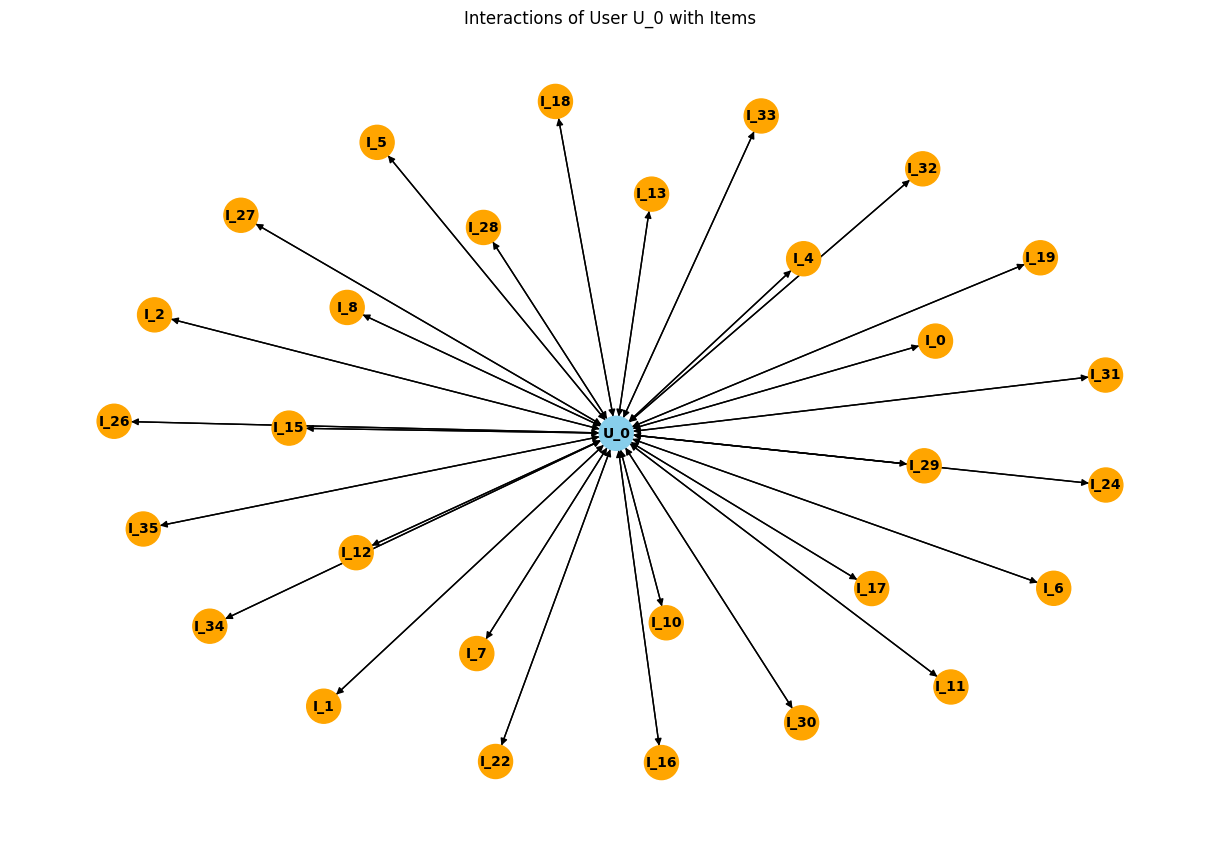

Relations of User U_0 with Items:
U_0 -> I_35: 1
U_0 -> I_34: 1
U_0 -> I_33: 1
U_0 -> I_32: 1
U_0 -> I_31: 1
U_0 -> I_30: 1
U_0 -> I_29: 1
U_0 -> I_28: 1
U_0 -> I_27: 1
U_0 -> I_26: 1
U_0 -> I_24: 1
U_0 -> I_22: 1
U_0 -> I_19: 1
U_0 -> I_18: 1
U_0 -> I_17: 1
U_0 -> I_16: 1
U_0 -> I_15: 1
U_0 -> I_13: 1
U_0 -> I_12: 1
U_0 -> I_11: 1
U_0 -> I_10: 1
U_0 -> I_8: 1
U_0 -> I_7: 1
U_0 -> I_6: 1
U_0 -> I_5: 1
U_0 -> I_4: 1
U_0 -> I_2: 1
U_0 -> I_1: 1
U_0 -> I_0: 1
Displaying User-User Connections


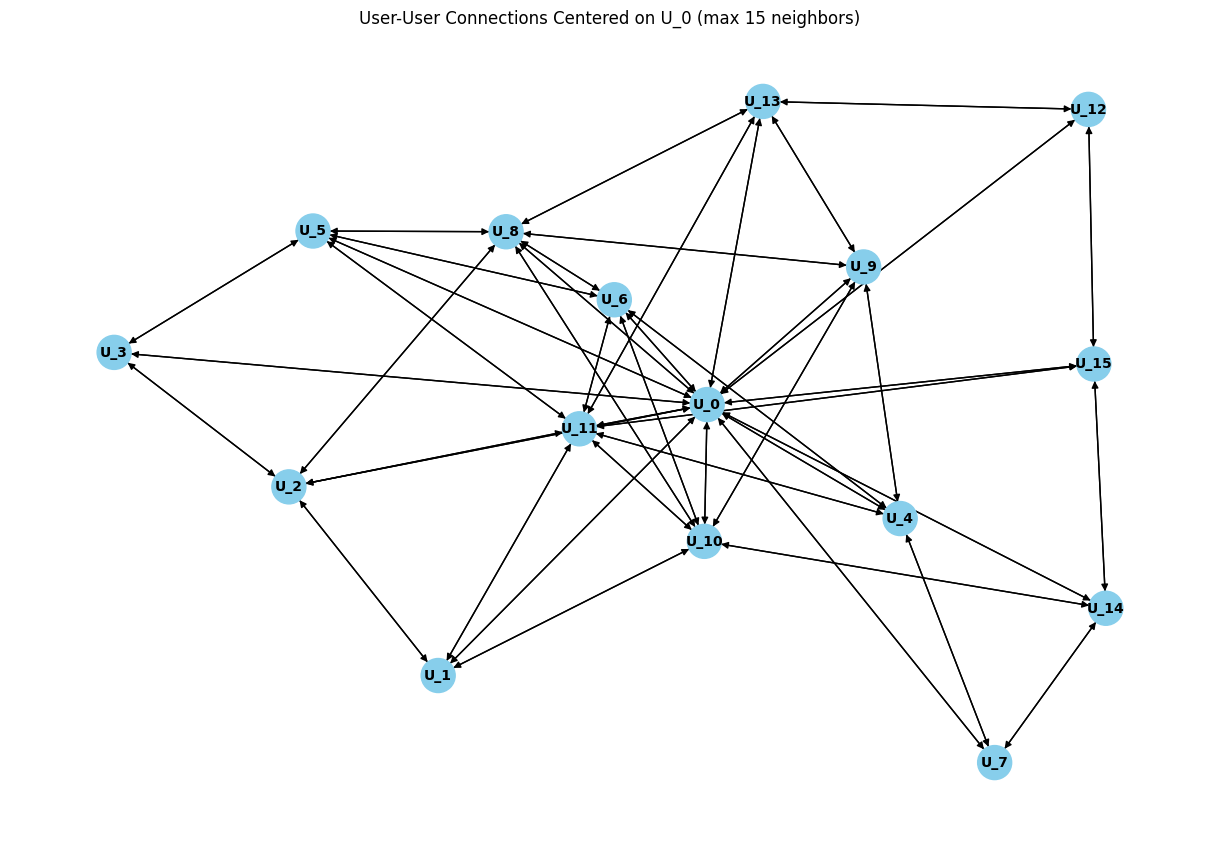

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import dgl

def visualize_user_item_graph(graph, num_users, num_items, user_id=0):
    """
    Visualize the interactions of a specific user with their items.
    Users are represented in blue and items in orange.
    """
    # Convert the DGL graph to a NetworkX graph for visualization
    nx_graph = graph.to_networkx()

    # Retrieve the neighbors (items) of the user
    neighbors = list(nx_graph.neighbors(user_id))
    
    # Create a subgraph centered on the user
    subgraph = nx_graph.subgraph([user_id] + neighbors)

    # Create labels for nodes: 'U_' prefix for users, 'I_' prefix for items
    labels = {user_id: f"U_{user_id}"}
    for node in neighbors:
        item_index = node - num_users
        labels[node] = f"I_{item_index}"

    # Node colors: blue for user, orange for items
    colors = ['skyblue' if node == user_id else 'orange' for node in subgraph.nodes]

    # Radial layout for highlighting connections
    pos = nx.spring_layout(subgraph, seed=42, center=(0.5, 0.5), scale=1.0)

    # Plotting
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, pos, labels=labels, node_size=600, node_color=colors, font_size=10, font_weight='bold')
    plt.title(f"Interactions of User U_{user_id} with Items")
    plt.show()


def visualize_user_user_graph(graph, num_users, user_id=0, max_neighbors=15):
    """
    Visualize the User-User connections centered around a specific user.
    All nodes (users) are represented in blue.
    - max_neighbors: Limits the number of neighbors to display.
    """
    # Convert the DGL graph to a NetworkX graph for visualization
    nx_graph = graph.to_networkx()

    # Retrieve the neighbors (other users) of the user
    neighbors = list(nx_graph.neighbors(user_id))
    
    # Limit the number of neighbors to display
    if max_neighbors and len(neighbors) > max_neighbors:
        neighbors = neighbors[:max_neighbors]
    
    # Create a subgraph centered on the user
    subgraph = nx_graph.subgraph([user_id] + neighbors)

    # Create labels for nodes with 'U_' prefix for users
    labels = {node: f"U_{node}" for node in subgraph.nodes}

    # Node colors: blue for all nodes
    colors = ['skyblue' for _ in subgraph.nodes]

    # Radial layout for highlighting connections
    pos = nx.spring_layout(subgraph, seed=42, center=(0.5, 0.5), scale=1.0)

    # Plotting
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, pos, labels=labels, node_size=600, node_color=colors, font_size=10, font_weight='bold')
    plt.title(f"User-User Connections Centered on U_{user_id} (max {max_neighbors} neighbors)")
    plt.show()

def print_user_item_relations(train_matrix, user_id):
    """
    Display the User-Item relationships (1 or 0) for a specific user.
    """
    # Extract the interactions for the specified user
    user_interactions = train_matrix.getrow(user_id).tocoo()

    # Print the user-item interactions
    print(f"Relations of User U_{user_id} with Items:")
    for item_idx, value in zip(user_interactions.col, user_interactions.data):
        print(f"U_{user_id} -> I_{item_idx}: {int(value)}")


# Check if the graphs are available
if dataset:
    user_id = 0  # Choose the user to visualize
    max_neighbors = 15  # Limit of neighbors to display

    print("Displaying User-Item Interactions")
    visualize_user_item_graph(ui_graph, NUM_USERS, NUM_ITEMS, user_id=user_id)
    
    print_user_item_relations(train_matrix, user_id)

    print("Displaying User-User Connections")
    visualize_user_user_graph(uu_graph, NUM_USERS, user_id=user_id, max_neighbors=max_neighbors)

else:
    print("Graphs are not yet created.")


In [11]:
# Save Matrices and Graphs (if needed later)

def save_matrix(matrix, path):
    """ Save matrix as .npy file """
    np.save(path, matrix)

def save_graph(graph, path):
    """ Save graph as .bin file """
    dgl.save_graphs(path, [graph])

if dataset:
    # Save matrices
    save_matrix(binary_train_matrix, os.path.join(SAVE_PATH, 'A_ui.npy'))
    save_matrix(trust_matrix.toarray(), os.path.join(SAVE_PATH, 'A_uu.npy'))

    # Save graphs
    save_graph(ui_graph, os.path.join(SAVE_PATH, 'ui_graph.bin'))
    save_graph(uu_graph, os.path.join(SAVE_PATH, 'uu_graph.bin'))

    print("Data successfully saved.")
else:
    print("Dataset not loaded. Cannot save data.")


Data successfully saved.


## Part II

In [12]:
# Construct the user-item matrix from the training matrix
# Each row represents a user, and each column represents an item

def construct_user_item_matrix(train_matrix):
    """
    Construct the user-item matrix from the training matrix.
    """
    # Convert the sparse matrix to a dense format (1/0 matrix)
    user_item_matrix = train_matrix.toarray()

    print(f"User-Item matrix shape: {user_item_matrix.shape}")
    return user_item_matrix

# Construct the matrix
if dataset:
    user_item_matrix = construct_user_item_matrix(train_matrix)
else:
    print("Dataset not loaded. Cannot construct the user-item matrix.")


User-Item matrix shape: (1925, 15053)


In [13]:
# Import PCA from scikit-learn for dimensionality reduction
from sklearn.decomposition import PCA

def apply_pca(user_item_matrix, n_components=50):
    """
    Apply PCA to reduce the dimensionality of the user-item matrix.
    
    Parameters:
    - user_item_matrix (numpy array or sparse matrix): The original user-item interaction matrix.
    - n_components (int): The number of principal components to keep.

    Returns:
    - reduced_matrix (numpy array): The matrix after dimensionality reduction.
    """
    # Initialize the PCA model with the specified number of components
    pca = PCA(n_components=n_components)
    
    # Apply PCA to the user-item matrix and obtain the reduced matrix
    reduced_matrix = pca.fit_transform(user_item_matrix)

    # Display the shape of the matrix after PCA
    print(f"Reduced matrix shape after PCA: {reduced_matrix.shape}")
    
    # Return the matrix with reduced dimensions
    return reduced_matrix

# Check if the dataset is available before applying PCA
if dataset:
    # Apply PCA to the user-item matrix with the specified number of components
    reduced_matrix = apply_pca(user_item_matrix, n_components=50)
else:
    # Display a message if the user-item matrix is not available
    print("User-Item matrix not available for PCA.")


Reduced matrix shape after PCA: (1925, 50)


In [14]:
# Apply KMeans and Spectral Clustering
from sklearn.cluster import KMeans, SpectralClustering

NUM_CLUSTERS = 10  # Number of clusters for KMeans and Spectral Clustering

def apply_clustering(data, num_clusters):
    """
    Apply KMeans and Spectral Clustering to the data.
    """
    # KMeans Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=42)
    spectral_labels = spectral.fit_predict(data)

    print("Clustering completed.")
    return kmeans_labels, spectral_labels

# Apply clustering
if dataset:
    kmeans_labels, spectral_labels = apply_clustering(reduced_matrix, NUM_CLUSTERS)
else:
    print("Reduced matrix not available for clustering.")


Clustering completed.


In [15]:
# Evaluate clustering using Silhouette Score and Davies-Bouldin Score
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clustering(data, labels, method):
    """
    Evaluate clustering using Silhouette Score and Davies-Bouldin Score.
    """
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)

    print(f"{method} - Silhouette Score: {silhouette:.4f}")
    print(f"{method} - Davies-Bouldin Score: {davies_bouldin:.4f}")

# Evaluate KMeans
evaluate_clustering(reduced_matrix, kmeans_labels, "KMeans")

# Evaluate Spectral Clustering
evaluate_clustering(reduced_matrix, spectral_labels, "Spectral Clustering")


KMeans - Silhouette Score: 0.7702
KMeans - Davies-Bouldin Score: 0.6936
Spectral Clustering - Silhouette Score: -0.1445
Spectral Clustering - Davies-Bouldin Score: 2.5122


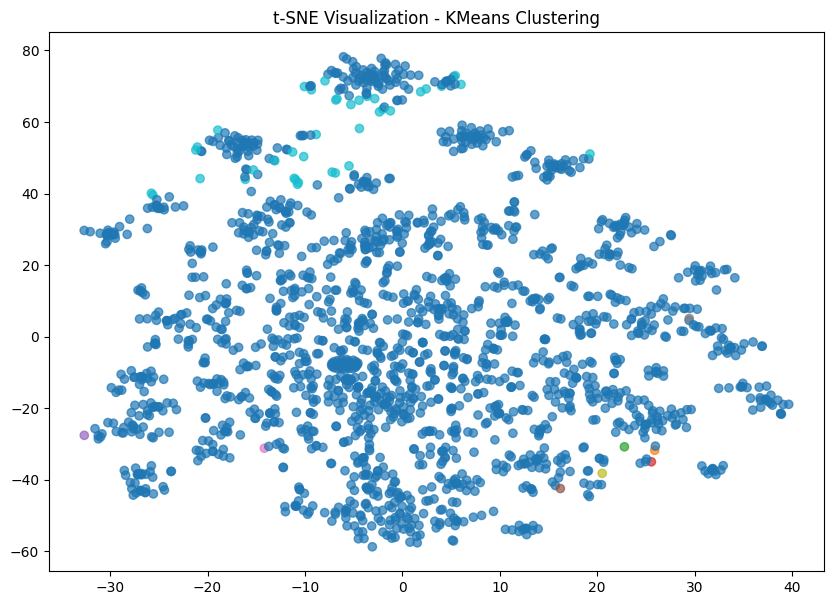

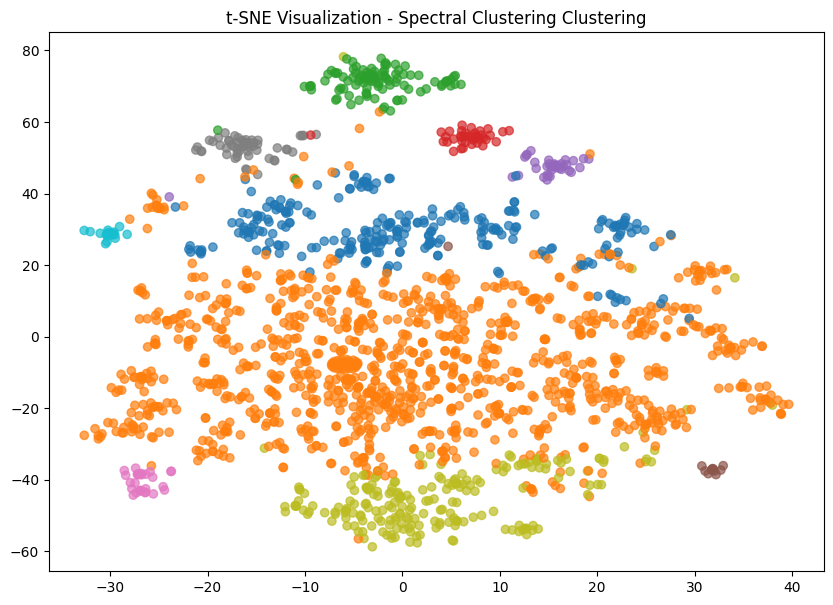

In [16]:
# Visualize clusters using t-SNE
from sklearn.manifold import TSNE

def visualize_clusters(data, labels, method):
    """
    Visualize clusters using t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)

    plt.figure(figsize=(10, 7))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f"t-SNE Visualization - {method} Clustering")
    plt.show()

# Visualize KMeans Clustering
visualize_clusters(reduced_matrix, kmeans_labels, "KMeans")

# Visualize Spectral Clustering
visualize_clusters(reduced_matrix, spectral_labels, "Spectral Clustering")


In [17]:
# Save cluster labels (if needed for later)

def save_cluster_labels(labels, method):
    """
    Save cluster labels as a dictionary.
    """
    cluster_dict = {f"U_{i}": label for i, label in enumerate(labels)}
    print(f"Cluster labels for {method}:")
    print(cluster_dict)

    return cluster_dict

# Save KMeans labels
kmeans_clusters = save_cluster_labels(kmeans_labels, "KMeans")

# Save Spectral Clustering labels
spectral_clusters = save_cluster_labels(spectral_labels, "Spectral Clustering")


Cluster labels for KMeans:
{'U_0': np.int32(0), 'U_1': np.int32(0), 'U_2': np.int32(0), 'U_3': np.int32(0), 'U_4': np.int32(3), 'U_5': np.int32(0), 'U_6': np.int32(0), 'U_7': np.int32(0), 'U_8': np.int32(0), 'U_9': np.int32(0), 'U_10': np.int32(0), 'U_11': np.int32(2), 'U_12': np.int32(0), 'U_13': np.int32(0), 'U_14': np.int32(0), 'U_15': np.int32(0), 'U_16': np.int32(0), 'U_17': np.int32(0), 'U_18': np.int32(0), 'U_19': np.int32(0), 'U_20': np.int32(0), 'U_21': np.int32(0), 'U_22': np.int32(0), 'U_23': np.int32(0), 'U_24': np.int32(0), 'U_25': np.int32(0), 'U_26': np.int32(0), 'U_27': np.int32(0), 'U_28': np.int32(0), 'U_29': np.int32(0), 'U_30': np.int32(0), 'U_31': np.int32(0), 'U_32': np.int32(0), 'U_33': np.int32(8), 'U_34': np.int32(0), 'U_35': np.int32(0), 'U_36': np.int32(0), 'U_37': np.int32(0), 'U_38': np.int32(0), 'U_39': np.int32(0), 'U_40': np.int32(0), 'U_41': np.int32(0), 'U_42': np.int32(0), 'U_43': np.int32(0), 'U_44': np.int32(0), 'U_45': np.int32(0), 'U_46': np.int32

## Part III

In [18]:
# Parameters for enhanced graph construction
INTRA_CLUSTER_WEIGHT = 1.0   # Weight for intra-cluster connections
INTER_CLUSTER_WEIGHT = 0.2   # Weight for inter-cluster connections

# Choose the clustering method ('kmeans' or 'spectral')
CLUSTERING_METHOD = 'spectral'

# Select the labels based on the chosen clustering method
if CLUSTERING_METHOD == 'kmeans':
    cluster_labels = kmeans_labels
elif CLUSTERING_METHOD == 'spectral':
    cluster_labels = spectral_labels
else:
    raise ValueError("Invalid clustering method selected.")

# Ensure that the clustering labels are available
assert len(cluster_labels) == NUM_USERS, "Cluster labels length mismatch."


In [19]:
import scipy.sparse as sp

def construct_enhanced_uu_graph(num_users, cluster_labels):
    """
    Construct the enhanced User-User graph based on cluster information.
    - Intra-cluster edges have higher weights.
    - Inter-cluster edges have lower weights.
    """
    # Initialize sparse adjacency matrix
    adj_matrix = sp.lil_matrix((num_users, num_users))

    # Iterate over all users to construct connections
    for i in range(num_users):
        for j in range(i + 1, num_users):
            if cluster_labels[i] == cluster_labels[j]:
                # Intra-cluster connection
                adj_matrix[i, j] = INTRA_CLUSTER_WEIGHT
                adj_matrix[j, i] = INTRA_CLUSTER_WEIGHT
            else:
                # Inter-cluster connection
                adj_matrix[i, j] = INTER_CLUSTER_WEIGHT
                adj_matrix[j, i] = INTER_CLUSTER_WEIGHT

    # Convert to CSR format for efficient processing
    adj_matrix = adj_matrix.tocsr()

    print(f"Enhanced User-User graph constructed with shape: {adj_matrix.shape}")
    return adj_matrix

# Construct the enhanced User-User graph
enhanced_uu_graph = construct_enhanced_uu_graph(NUM_USERS, cluster_labels)


Enhanced User-User graph constructed with shape: (1925, 1925)


In [20]:
def update_user_item_graph(train_matrix):
    """
    Update the User-Item graph by maintaining original connections.
    """
    # The User-Item matrix is directly derived from the original training matrix
    updated_ui_graph = train_matrix.tocsr()
    print(f"Updated User-Item graph shape: {updated_ui_graph.shape}")
    return updated_ui_graph

# Update User-Item graph
updated_ui_graph = update_user_item_graph(train_matrix)


Updated User-Item graph shape: (1925, 15053)


In [21]:
def create_feature_matrices(num_users, num_items, cluster_labels):
    """
    Create feature matrices X_ui and X_uu based on cluster labels.
    - X_uu: Each user's cluster is encoded as a feature.
    - X_ui: The User-Item matrix itself is used as a feature matrix.
    """
    # X_uu: Feature matrix for User-User graph (clusters as features)
    X_uu = np.zeros((num_users, NUM_CLUSTERS))
    for i in range(num_users):
        X_uu[i, cluster_labels[i]] = 1

    # X_ui: Feature matrix for User-Item graph (original matrix as features)
    X_ui = train_matrix.toarray()

    print(f"X_uu shape: {X_uu.shape}")
    print(f"X_ui shape: {X_ui.shape}")
    return X_ui, X_uu

# Create feature matrices
X_ui, X_uu = create_feature_matrices(NUM_USERS, NUM_ITEMS, cluster_labels)


X_uu shape: (1925, 10)
X_ui shape: (1925, 15053)


Connexions de l'utilisateur 0 : [[0.  0.2 0.2 ... 0.2 0.2 0.2]]


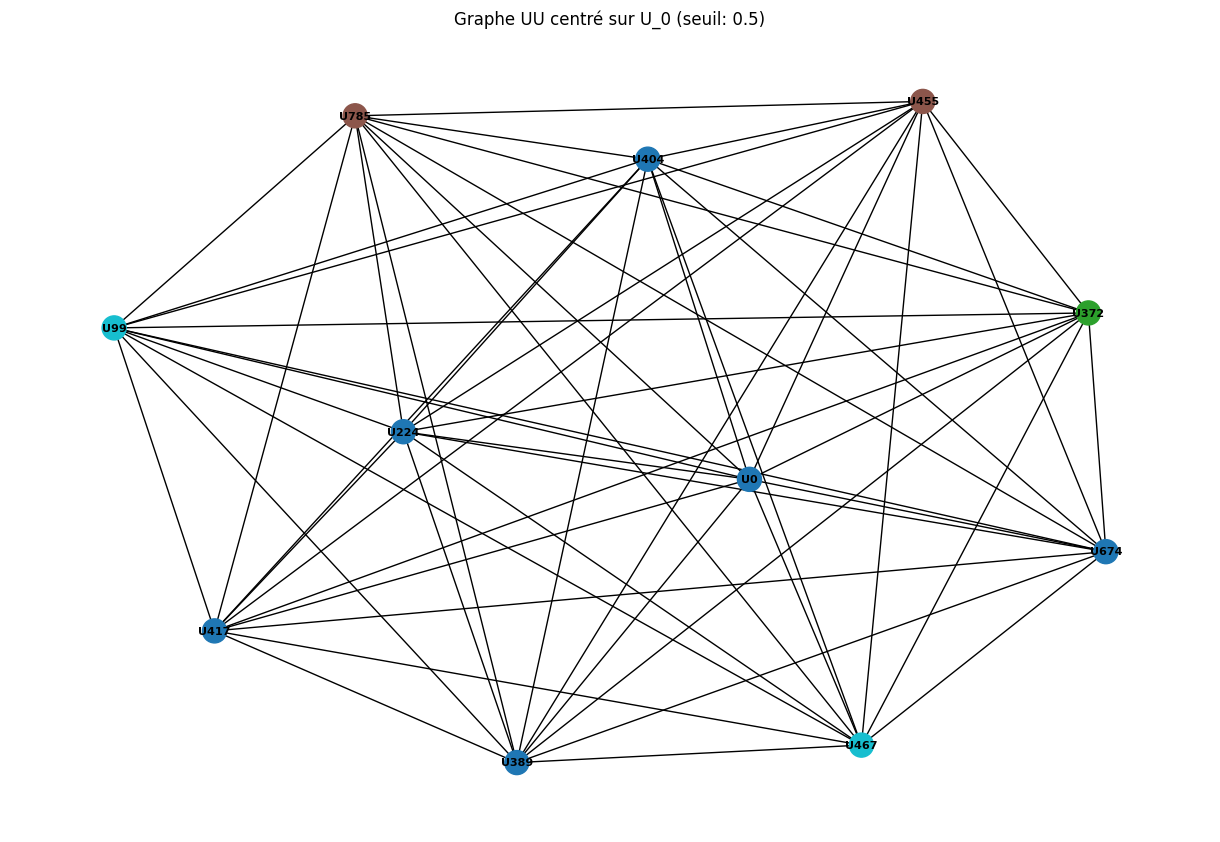

In [33]:
def visualize_partial_uu_graph(adj_matrix, cluster_labels, user_id=0, max_neighbors=10, threshold=0.0):
    """
    Visualise un sous-graphe du graphe UU centré sur un utilisateur donné.
    Seules les connexions réelles avec un poids > threshold sont affichées.
    """

    # ➕ Affichage des connexions de l'utilisateur dans la matrice UU
    print(f"Connexions de l'utilisateur {user_id} :", adj_matrix[user_id].toarray())

    # Convert to NetworkX graph (weighted if applicable)
    nx_graph = nx.from_scipy_sparse_array(adj_matrix)

    # Garder uniquement les voisins avec un poids > threshold
    neighbors = [
        neighbor for neighbor in nx_graph.neighbors(user_id)
        if nx_graph[user_id][neighbor].get('weight', 1.0) > threshold
    ]
    neighbors = neighbors[:max_neighbors]

    # Sous-graphe centré autour de l'utilisateur
    nodes = [user_id] + neighbors
    subgraph = nx_graph.subgraph(nodes)

    # Couleurs par cluster
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.tab10(unique_labels / unique_labels.max())
    node_colors = [colors[cluster_labels[node]] for node in subgraph.nodes()]

    # Étiquettes
    labels = {node: f"U{node}" for node in subgraph.nodes()}

    # Affichage
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, labels=labels, node_color=node_colors, node_size=300, font_size=8, font_weight='bold')
    plt.title(f"Graphe UU centré sur U_{user_id} (seuil: {threshold})")
    plt.show()

visualize_partial_uu_graph(enhanced_uu_graph, cluster_labels, user_id=0, max_neighbors=10, threshold=0.5)


## Part IV

In [2]:
import dgl, math, torch
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn.pytorch import GraphConv
import math
from torch.nn.init import xavier_normal_, constant_, xavier_uniform_




class UUGCNLayer(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 weight=False,
                 bias=False,
                 activation=None):
        super(UUGCNLayer, self).__init__()
        self.bias = bias
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.weight = weight
        if self.weight:
            self.u_w = nn.Parameter(torch.Tensor(in_feats, out_feats))
            xavier_uniform_(self.u_w)
        self._activation = activation

    # def forward(self, graph, feat):
    def forward(self, graph, u_f):
        with graph.local_scope():
            if self.weight:
                u_f = torch.mm(u_f, self.u_w)
            node_f = u_f
            # D^-1/2
            # degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
            degs = graph.out_degrees().to(u_f.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5).view(-1, 1)
            # norm = norm.view(-1,1)
            # shp = norm.shape + (1,) * (feat.dim() - 1)
            # norm = t.reshape(norm, shp)

            node_f = node_f * norm

            graph.ndata['n_f'] = node_f
            # graph.edata['e_f'] = e_f
            graph.update_all(fn.copy_u(u='n_f', out='m'), reduce_func=fn.sum(msg='m', out='n_f'))

            rst = graph.ndata['n_f']

            degs = graph.in_degrees().to(u_f.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5).view(-1, 1)
            # shp = norm.shape + (1,) * (feat.dim() - 1)
            # norm = t.reshape(norm, shp)
            rst = rst * norm

            if self._activation is not None:
                rst = self._activation(rst)

            return rst
class GCNLayer(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 weight=False,
                 bias=False,
                 activation=None):
        super(GCNLayer, self).__init__()
        self.bias = bias
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.weight = weight
        if self.weight:
            self.u_w = nn.Parameter(torch.Tensor(in_feats, out_feats))
            self.v_w = nn.Parameter(torch.Tensor(in_feats, out_feats))
            # self.e_w = nn.Parameter(t.Tensor(in_feats, out_feats))
            xavier_uniform_(self.u_w)
            xavier_uniform_(self.v_w)
            # init.xavier_uniform_(self.e_w)
        self._activation = activation

    # def forward(self, graph, feat):
    def forward(self, graph, u_f, v_f):
        with graph.local_scope():
            if self.weight:
                u_f = torch.mm(u_f, self.u_w)
                v_f = torch.mm(v_f, self.v_w)
                # e_f = t.mm(e_f, self.e_w)
            node_f = torch.cat([u_f, v_f], dim=0)
            # D^-1/2
            # degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
            degs = graph.out_degrees().to(u_f.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5).view(-1, 1)
            # norm = norm.view(-1,1)
            # shp = norm.shape + (1,) * (feat.dim() - 1)
            # norm = t.reshape(norm, shp)

            node_f = node_f * norm

            graph.ndata['n_f'] = node_f
            # graph.edata['e_f'] = e_f
            graph.update_all(fn.copy_u(u='n_f', out='m'), reduce_func=fn.sum(msg='m', out='n_f'))

            rst = graph.ndata['n_f']

            degs = graph.in_degrees().to(u_f.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5).view(-1, 1)
            # shp = norm.shape + (1,) * (feat.dim() - 1)
            # norm = t.reshape(norm, shp)
            rst = rst * norm

            if self._activation is not None:
                rst = self._activation(rst)

            return rst

class GCNModel(nn.Module):
    def __init__(self,args, n_user,n_item):
        super(GCNModel, self).__init__()
        self.n_user = n_user
        self.n_item = n_item
        self.n_hid = args.n_hid
        self.n_layers = args.n_layers
        self.s_layers = args.s_layers
        self.embedding_dict = self.init_weight(n_user, n_item, self.n_hid)
        self.act = nn.LeakyReLU(0.5, inplace=True)
        self.layers = nn.ModuleList()
        self.uu_Layers = nn.ModuleList()
        self.weight = args.weight
        for i in range(0, self.n_layers):
            self.layers.append(GCNLayer(self.n_hid, self.n_hid, weight=self.weight, bias=False, activation=self.act))
        for i in range(0, self.s_layers):
            self.uu_Layers.append(UUGCNLayer(self.n_hid,self.n_hid,weight=self.weight, bias=False, activation=self.act))
    def init_weight(self, userNum, itemNum, hide_dim):
        initializer = nn.init.xavier_uniform_

        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(torch.empty(userNum, hide_dim))),
            'item_emb': nn.Parameter(initializer(torch.empty(itemNum, hide_dim))),
        })
        return embedding_dict
    def forward(self, uigraph, uugraph, isTrain=True):

        init_embedding = torch.concat([self.embedding_dict['user_emb'],self.embedding_dict['item_emb']],axis=0)
        init_user_embedding = self.embedding_dict['user_emb']
        all_embeddings = [init_embedding]
        all_uu_embeddings = [init_user_embedding]

        for i, layer in enumerate(self.layers):
            if i == 0:
                embeddings = layer(uigraph, self.embedding_dict['user_emb'], self.embedding_dict['item_emb'])
            else:
                embeddings = layer(uigraph, embeddings[:self.n_user], embeddings[self.n_user:])

            norm_embeddings = F.normalize(embeddings, p=2, dim=1)
            all_embeddings += [norm_embeddings]
        ui_embeddings = sum(all_embeddings)

        for i, layer in enumerate(self.uu_Layers):
            if i == 0:
                embeddings = layer(uugraph, self.embedding_dict['user_emb'])
            else:
                embeddings = layer(uugraph, embeddings)
            norm_embeddings = F.normalize(embeddings, p=2, dim=1)
            all_uu_embeddings +=[norm_embeddings]
        uu_embeddings = sum(all_uu_embeddings)

        return ui_embeddings,uu_embeddings




#Social hidden fully-connected architecture
class SDNet(nn.Module):
    """
    A deep neural network for the reverse diffusion preocess.
    """

    def __init__(self, in_dims, out_dims, emb_size, time_type="cat", norm=False, dropout=0.5):
        super(SDNet, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        assert out_dims[0] == in_dims[-1], "In and out dimensions must equal to each other."
        self.time_type = time_type
        self.time_emb_dim = emb_size
        self.norm = norm

        self.emb_layer = nn.Linear(self.time_emb_dim, self.time_emb_dim)

        if self.time_type == "cat":
            in_dims_temp = [self.in_dims[0] + self.time_emb_dim] + self.in_dims[1:]
        else:
            raise ValueError("Unimplemented timestep embedding type %s" % self.time_type)
        out_dims_temp = self.out_dims

        self.in_layers = nn.ModuleList([nn.Linear(d_in, d_out) \
                                        for d_in, d_out in zip(in_dims_temp[:-1], in_dims_temp[1:])])
        self.out_layers = nn.ModuleList([nn.Linear(d_in, d_out) \
                                         for d_in, d_out in zip(out_dims_temp[:-1], out_dims_temp[1:])])

        self.drop = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        for layer in self.in_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0 / (fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for weights
            layer.bias.data.normal_(0.0, 0.001)

        for layer in self.out_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0 / (fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for weights
            layer.bias.data.normal_(0.0, 0.001)

        size = self.emb_layer.weight.size()
        fan_out = size[0]
        fan_in = size[1]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        self.emb_layer.weight.data.normal_(0.0, std)
        self.emb_layer.bias.data.normal_(0.0, 0.001)

    def forward(self, x, timesteps):
        time_emb = timestep_embedding(timesteps, self.time_emb_dim).to(x.device)
        emb = self.emb_layer(time_emb)
        if self.norm:
            x = F.normalize(x)
        x = self.drop(x)
        h = torch.cat([x, emb], dim=-1)
        for i, layer in enumerate(self.in_layers):
            h = layer(h)
            h = torch.tanh(h)

        for i, layer in enumerate(self.out_layers):
            h = layer(h)
            if i != len(self.out_layers) - 1:
                h = torch.tanh(h)

        return h


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """

    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))



In [3]:
import enum
import math
import numpy as np
import torch as th
import torch.nn.functional as F
import torch.nn as nn
class DiffusionProcess(nn.Module):
    def __init__(self,noise_schedule, noise_scale, noise_min, noise_max,steps, device, keep_num=10):
        super(DiffusionProcess, self).__init__()
        self.noise_schedule = noise_schedule
        self.noise_scale = noise_scale
        self.noise_min = noise_min
        self.noise_max = noise_max
        self.steps = steps
        self.device = device

        self.keep_num = keep_num
        self.Lt_record = th.zeros(steps, keep_num, dtype=th.float64).to(device)
        self.Lt_count = th.zeros(steps, dtype=int).to(device)


        #The important parameters for gaussian diffusion
        self.beta_nums = th.tensor(self.betas_num(), dtype=th.float64).to(self.device)
        assert len(self.beta_nums.shape) == 1, "betas must be 1-D"
        assert len(self.beta_nums) == self.steps, "num of betas must equal to diffusion steps"
        assert (self.beta_nums > 0).all() and (self.beta_nums <= 1).all(), "betas out of range"

        self.diffusion_setting()

    def betas_num(self):
        """
        Given the schedule name, create the betas for the diffusion process.
        """
        st_bound = self.noise_scale * self.noise_min
        e_bound = self.noise_scale * self.noise_max
        if self.noise_schedule == "linear":
            return np.linspace(st_bound, e_bound, self.steps, dtype=np.float64)
        else:
            return betas_from_linear_variance(self.steps, np.linspace(st_bound, e_bound, self.steps, dtype=np.float64))
    def diffusion_setting(self):
        alphas = 1.0 - self.beta_nums
        self.alphas_cumprod = th.cumprod(alphas, axis=0).to(self.device)
        self.alphas_cumprod_prev = th.cat([th.tensor([1.0]).to(self.device), self.alphas_cumprod[:-1]]).to(self.device)  # alpha_{t-1}
        self.alphas_cumprod_next = th.cat([self.alphas_cumprod[1:], th.tensor([0.0]).to(self.device)]).to(self.device)  # alpha_{t+1}
        assert self.alphas_cumprod_prev.shape == (self.steps,)

        self.sqrt_alphas_cumprod = th.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = th.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = th.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = th.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = th.sqrt(1.0 / self.alphas_cumprod - 1)

        self.posterior_variance = (
            self.beta_nums * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

        self.posterior_log_variance_clipped = th.log(
            th.cat([self.posterior_variance[1].unsqueeze(0), self.posterior_variance[1:]])
        )
        self.posterior_mean_coef1 = (
            self.beta_nums * th.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * th.sqrt(alphas)
            / (1.0 - self.alphas_cumprod)
        )
    
   

    def caculate_losses(self, model, emb_s, reweight=False):
        batch_size, device = emb_s.size(0), emb_s.device
        ts, pt = self.sample_timesteps(batch_size, device, 'uniform')
        noise = th.randn_like(emb_s)
        emb_t = self.forward_process(emb_s, ts, noise)
        terms = {}
        model_output = model(emb_t, ts)


        assert model_output.shape == emb_s.shape

        mse = mean_flat((emb_s - model_output) ** 2)

        if reweight == True:

            weight = self.SNR(ts - 1) - self.SNR(ts)
            weight = th.where((ts == 0), 1.0, weight)
            loss = mse

        else:
            weight = th.tensor([1.0] * len(model_output)).to(device)

        terms["loss"] = weight * loss
        terms["pred_xstart"] = model_output
        return terms

    def p_sample(self, model, emb_s, steps, sampling_noise=False):
        assert steps <= self.steps, "Too much steps in inference."
        if steps == 0:
            emb_t = emb_s
        else:
            t = th.tensor([steps - 1] * emb_s.shape[0]).to(emb_s.device)
            emb_t = self.q_sample(emb_s, t)

        indices = list(range(self.steps))[::-1]

        if self.noise_scale == 0.:
            for i in indices:
                t = th.tensor([i] * emb_t.shape[0]).to(emb_s.device)
                emb_t = model(emb_t, t)
            return emb_t

        for i in indices:
            t = th.tensor([i] * emb_t.shape[0]).to(emb_s.device)
            out = self.p_mean_variance(model, emb_t, t)
            if sampling_noise:
                noise = th.randn_like(emb_t)
                nonzero_mask = (
                    (t != 0).float().view(-1, *([1] * (len(emb_t.shape) - 1)))
                )  # no noise when t == 0
                emb_t = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
            else:
                emb_t = out["mean"]
        return emb_t
    
 
       

    def sample_timesteps(self, batch_size, device, method='uniform', uniform_prob=0.001):
        if method == 'importance':  # importance sampling
            if not (self.Lt_count == self.keep_num).all():
                return self.sample_timesteps(batch_size, device, method='uniform')

            Lt_sqrt = th.sqrt(th.mean(self.Lt_record ** 2, axis=-1))
            pt_all = Lt_sqrt / th.sum(Lt_sqrt)
            pt_all *= 1 - uniform_prob
            pt_all += uniform_prob / len(pt_all)

            assert pt_all.sum(-1) - 1. < 1e-5

            t = th.multinomial(pt_all, num_samples=batch_size, replacement=True)
            pt = pt_all.gather(dim=0, index=t) * len(pt_all)

            return t, pt

        elif method == 'uniform':  # uniform sampling
            t = th.randint(0, self.steps, (batch_size,), device=device).long()
            pt = th.ones_like(t).float()

            return t, pt

        else:
            raise ValueError

    def forward_process(self, emb_s, t, noise=None):
        if noise is None:
            noise = th.randn_like(emb_s)
        assert noise.shape == emb_s.shape
        return (
                self._extract_into_tensor(self.sqrt_alphas_cumprod, t, emb_s.shape) * emb_s
                + self._extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, emb_s.shape)
                * noise
        )

    def q_posterior_mean_variance(self, emb_s, emb_t, t):
        """
        Compute the mean and variance of the diffusion posterior:
            q(x_{t-1} | x_t, x_0)
        """
        assert emb_s.shape == emb_t.shape
        posterior_mean = (
                self._extract_into_tensor(self.posterior_mean_coef1, t, emb_t.shape) * emb_s
                + self._extract_into_tensor(self.posterior_mean_coef2, t, emb_t.shape) * emb_t
        )
        posterior_variance = self._extract_into_tensor(self.posterior_variance, t, emb_t.shape)
        posterior_log_variance_clipped = self._extract_into_tensor(
            self.posterior_log_variance_clipped, t, emb_t.shape
        )
        assert (
                posterior_mean.shape[0]
                == posterior_variance.shape[0]
                == posterior_log_variance_clipped.shape[0]
                == emb_s.shape[0]
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, model, x, t):
        """
        Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
        the initial x, x_0.
        """
        B, C = x.shape[:2]
        assert t.shape == (B,)
        model_output = model(x, t)

        model_variance = self.posterior_variance
        model_log_variance = self.posterior_log_variance_clipped

        model_variance = self._extract_into_tensor(model_variance, t, x.shape)
        model_log_variance = self._extract_into_tensor(model_log_variance, t, x.shape)
        pred_xstart = model_output

        model_mean, _, _ = self.q_posterior_mean_variance(emb_s=pred_xstart, emb_t=x, t=t)

        assert (
                model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
        )

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def _predict_xstart_from_eps(self, emb_t, t, eps):
        assert emb_t.shape == eps.shape
        return (
                self._extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, emb_t.shape) * emb_t
                - self._extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, emb_t.shape) * eps
        )

    def SNR(self, t):
        """
        Compute the signal-to-noise ratio for a single timestep.
        """
        self.alphas_cumprod = self.alphas_cumprod.to(t.device)
        return self.alphas_cumprod[t] / (1 - self.alphas_cumprod[t])

    def _extract_into_tensor(self, arr, timesteps, broadcast_shape):
        """
        Extract values from a 1-D numpy array for a batch of indices.

        :param arr: the 1-D numpy array.
        :param timesteps: a tensor of indices into the array to extract.
        :param broadcast_shape: a larger shape of K dimensions with the batch
                                dimension equal to the length of timesteps.
        :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
        """
        # res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
        arr = arr.to(timesteps.device)
        res = arr[timesteps].float()
        while len(res.shape) < len(broadcast_shape):
            res = res[..., None]
        return res.expand(broadcast_shape)



def betas_from_linear_variance(steps, variance, max_beta=0.999):
    alpha_bar = 1 - variance
    betas = []
    betas.append(1 - alpha_bar[0])
    for i in range(1, steps):
        betas.append(min(1 - alpha_bar[i] / alpha_bar[i - 1], max_beta))
    return np.array(betas)
def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.

    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, th.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for th.exp().
    logvar1, logvar2 = [
        x if isinstance(x, th.Tensor) else th.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + th.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * th.exp(-logvar2)
    )

def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))


In [ ]:
import torch, pickle, time, os
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from param import args
from DataHander import DataHandler
from models.model import SDNet ,GCNModel

from utils import load_model, save_model, fix_random_seed_as
from tqdm import tqdm

from models import diffusion_process as dp
from Utils.Utils import *
import logging
import sys

class Coach:
    def __init__(self, handler):
        self.args = args
        self.device = torch.device('cuda' if args.cuda and torch.cuda.is_available() else 'cpu')
        self.handler = handler
        self.train_loader = self.handler.trainloader
        self.valloader = self.handler.valloader
        self.testloader = self.handler.testloader
        self.n_user, self.n_item = self.handler.n_user, self.handler.n_item
        self.uiGraph = self.handler.ui_graph.to(self.device)
        self.uuGraph = self.handler.uu_graph.to(self.device)

        self.GCNModel = GCNModel(args, self.n_user, self.n_item).to(self.device)
        # Build diffusion process
        output_dims = [args.dims] + [args.n_hid]
        input_dims = output_dims[::-1]
        self.SDNet = SDNet(input_dims, output_dims, args.emb_size, time_type="cat", norm=args.norm).to(self.device)

        self.DiffProcess = dp.DiffusionProcess(args.noise_schedule, args.noise_scale, args.noise_min, args.noise_max, args.steps, self.device).to(self.device)

        self.optimizer1 = torch.optim.Adam([
            {'params': self.GCNModel.parameters(), 'weight_decay': 0},
        ], lr=args.lr)
        self.optimizer2 = torch.optim.Adam([
            {'params': self.SDNet.parameters(), 'weight_decay': 0},
        ], lr=args.difflr)
        self.scheduler1 = torch.optim.lr_scheduler.StepLR(
            self.optimizer1,
            step_size=args.decay_step,
            gamma=args.decay
        )
        self.scheduler2 = torch.optim.lr_scheduler.StepLR(
            self.optimizer2,
            step_size=args.decay_step,
            gamma=args.decay
        )

        self.train_loss = []
        self.his_recall = []
        self.his_ndcg  = []

    def train(self):
        args = self.args
        self.save_history = True
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO, format=log_format, datefmt='%m/%d %I:%M:%S %p')
        log_save = './History/' + args.dataset + '/'
        log_file = args.save_name
        fname = f'{log_file}.txt'
        fh = logging.FileHandler(os.path.join(log_save, fname))
        fh.setFormatter(logging.Formatter(log_format))
        logger = logging.getLogger()
        logger.addHandler(fh)
        logger.info(args)
        logger.info('================')
        best_recall, best_ndcg, best_epoch, wait = 0, 0, 0, 0
        start_time = time.time()
        for self.epoch in range(1, args.n_epoch + 1):
            epoch_losses = self.train_one_epoch()
            self.train_loss.append(epoch_losses)
            print('epoch {} done! elapsed {:.2f}.s, epoch_losses {}'.format(
                self.epoch, time.time() - start_time, epoch_losses
            ), flush=True)
            if self.epoch % 5 == 0:
                recall, ndcg = self.test(self.testloader)

                # Record history of recall and ndcg
                self.his_recall.append(recall)
                self.his_ndcg.append(ndcg)
                cur_best = recall + ndcg > best_recall + best_ndcg
                if cur_best:
                    best_recall, best_ndcg, best_epoch = recall, ndcg, self.epoch
                    wait = 0
                else:
                    wait += 1
                logger.info('+ epoch {} tested, elapsed {:.2f}s, Recall@{}: {:.4f}, NDCG@{}: {:.4f}'.format(
                    self.epoch, time.time() - start_time, args.topk, recall, args.topk, ndcg))
                if args.model_dir and cur_best:
                    desc = args.save_name
                    perf = ''
                    fname = f'{args.desc}_{desc}_{perf}.pth'

                    save_model(self.GCNModel, self.SDNet, os.path.join(args.model_dir, fname), self.optimizer1, self.optimizer2)
            if self.save_history:
                self.saveHistory()

            if wait >= args.patience:
                print(f'Early stop at epoch {self.epoch}, best epoch {best_epoch}')
                break

        print(f'Best  Recall@{args.topk} {best_recall:.6f}, NDCG@{args.topk} {best_ndcg:.6f}', flush=True)
        # Denoising evaluation
        print("\n=== Denoising Evaluation ===")
        self.evaluate_denoising()

    def evaluate_denoising(self):
        """
        Evaluate denoising effectiveness using cosine similarity
        between original and reconstructed embeddings.
        """
        self.SDNet.eval()
        self.GCNModel.eval()

        with torch.no_grad():
            # Generate embeddings
            uiEmbeds, uuEmbeds = self.GCNModel(self.uiGraph, self.uuGraph, True)

            # Select a few users for evaluation
            num_samples = 256
            sample_users = torch.randint(0, self.n_user, (num_samples,)).long().to(self.device)
            original_embeddings = uuEmbeds[sample_users]

            # Reconstruct using SDNet
            reconstructed_embeddings = self.DiffProcess.p_sample(
                self.SDNet, original_embeddings, args.sampling_steps, args.sampling_noise
            )

            # Compute cosine similarity
            cos_sim = F.cosine_similarity(original_embeddings, reconstructed_embeddings, dim=1)
            similarity_score = cos_sim.mean().item()

            print(f"Similarity Score after Denoising: {similarity_score:.4f}")

        return similarity_score

    def train_one_epoch(self):
        self.SDNet.train()
        self.GCNModel.train()
        dataloader = self.train_loader
        epoch_losses = [0] * 3
        dataloader.dataset.negSampling()
        tqdm_dataloader = tqdm(dataloader)
        since = time.time()

        for iteration, batch in enumerate(tqdm_dataloader):
            user_idx, pos_idx, neg_idx = batch
            user_idx = user_idx.long()
            pos_idx = pos_idx.long()
            neg_idx = neg_idx.long()

            uiEmbeds, uuEmbeds = self.GCNModel(self.uiGraph, self.uuGraph, True)
            uEmbeds = uiEmbeds[:self.n_user]
            iEmbeds = uiEmbeds[self.n_user:]
            user = uEmbeds[user_idx]
            pos = iEmbeds[pos_idx]
            neg = iEmbeds[neg_idx]

            uu_terms = self.DiffProcess.caculate_losses(self.SDNet, uuEmbeds[user_idx], args.reweight)
            uuelbo = uu_terms["loss"].mean()
            user = user + uu_terms["pred_xstart"]
            diffloss = uuelbo
            scoreDiff = pairPredict(user, pos, neg)
            bprLoss = - (scoreDiff).sigmoid().log().sum() / args.batch_size
            regLoss = ((torch.norm(user) ** 2 + torch.norm(pos) ** 2 + torch.norm(neg) ** 2) * args.reg) / args.batch_size
            loss = bprLoss + regLoss
            losses = [bprLoss.item(), regLoss.item()]

            loss = diffloss + loss
            losses.append(diffloss.item())

            self.optimizer1.zero_grad()
            self.optimizer2.zero_grad()
            loss.backward()
            self.optimizer1.step()
            self.optimizer2.step()

            epoch_losses = [x + y for x, y in zip(epoch_losses, losses)]

        if self.scheduler1 is not None:
            self.scheduler1.step()
            self.scheduler2.step()

        epoch_losses = [sum(epoch_losses)] + epoch_losses
        time_elapsed = time.time() - since
        print('Training complete in {:.4f}s'.format(time_elapsed))
        return epoch_losses

    def calcRes(self, topLocs, tstLocs, batIds):
        assert topLocs.shape[0] == len(batIds)
        allRecall = allNdcg = 0
        for i in range(len(batIds)):
            temTopLocs = list(topLocs[i])
            temTstLocs = tstLocs[batIds[i]]
            tstNum = len(temTstLocs)
            maxDcg = np.sum([np.reciprocal(np.log2(loc + 2)) for loc in range(min(tstNum, args.topk))])
            recall = dcg = 0
            for val in temTstLocs:
                if val in temTopLocs:
                    recall += 1
                    dcg += np.reciprocal(np.log2(temTopLocs.index(val) + 2))
            recall = recall / tstNum
            ndcg = dcg / maxDcg
            allRecall += recall
            allNdcg += ndcg
        return allRecall, allNdcg

    def test(self, dataloader):
        self.SDNet.eval()
        self.GCNModel.eval()
        Recall, NDCG = [0] * 2
        num = dataloader.dataset.__len__()

        since = time.time()
        with torch.no_grad():
            uiEmbeds, uuEmbeds = self.GCNModel(self.uiGraph, self.uuGraph, True)
            tqdm_dataloader = tqdm(dataloader)
            for iteration, batch in enumerate(tqdm_dataloader, start=1):
                user_idx, trnMask = batch
                user_idx = user_idx.long()
                trnMask = trnMask

                uEmbeds = uiEmbeds[:self.n_user]
                iEmbeds = uiEmbeds[self.n_user:]
                user = uEmbeds[user_idx]

                uuemb = uuEmbeds[user_idx]
                user_predict = self.DiffProcess.p_sample(self.SDNet, uuemb, args.sampling_steps, args.sampling_noise)
                user = user + user_predict
                allPreds = torch.mm(user, torch.transpose(iEmbeds, 1, 0)) * (1 - trnMask) - trnMask * 1e8
                _, topLocs = torch.topk(allPreds, args.topk)
                recall, ndcg = self.calcRes(topLocs.cpu().numpy(), dataloader.dataset.tstLocs, user_idx)
                Recall += recall
                NDCG += ndcg
            time_elapsed = time.time() - since
            print('Testing complete in {:.4f}s'.format(time_elapsed))
            Recall = Recall / num
            NDCG = NDCG / num
        return Recall, NDCG

    def saveHistory(self):
        history = dict()
        history['loss'] = self.train_loss
        history['Recall'] = self.his_recall
        history['NDCG'] = self.his_ndcg
        ModelName = "SDR"
        desc = args.save_name
        perf = ''
        fname = f'{args.desc}_{desc}_{perf}.his'

        with open('./History/' + args.dataset + '/' + fname, 'wb') as fs:
            pickle.dump(history, fs)

if __name__ == "__main__":
    os.environ['CUDA_VISIBLE_DEVICES'] = args.cuda
    fix_random_seed_as(args.seed)

    handler = DataHandler()
    handler.LoadData()
    app = Coach(handler)
    app.train()


05/20 09:58:17 AM Namespace(desc='', cuda='0', seed=2023, n_hid=64, n_layers=2, s_layers=2, weight=True, dropout=0, lr=0.003, difflr=0.0007, reg=0.01, decay=0.98, decay_step=2, n_epoch=30, batch_size=8192, patience=10, topk=50, test_batch_size=2048, dataset='epinions', num_workers=0, save_name='tem', checkpoint='./Model/epinions/_tem_.pth', model_dir='./Model/epinions/', time_type='cat', dims=64, norm=True, emb_size=16, steps=20, noise_schedule='linear-var', noise_scale=3.0, noise_min=0.1, noise_max=0.3, sampling_noise=True, sampling_steps=10, reweight=True, user=np.int64(14680), item=np.int64(233261))
05/20 09:58:17 AM ================


  0%|          | 0/55 [00:00<?, ?it/s]c:\Users\medta\AppData\Local\Programs\Python\Python310\lib\site-packages\dgl\backend\pytorch\tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
100%|██████████| 55/55 [00:50<00:00,  1.09it/s]

Training complete in 50.5357s
epoch 1 done! elapsed 52.43.s, epoch_losses [17.66314207988654, 10.970318131148815, 6.336877427995205, 0.3559465207425214]



100%|██████████| 55/55 [00:52<00:00,  1.04it/s]

Training complete in 52.7982s
epoch 2 done! elapsed 107.24.s, epoch_losses [11.906951761506777, 5.653860475867987, 6.137764908373356, 0.11532637726543384]



100%|██████████| 55/55 [00:52<00:00,  1.05it/s]

Training complete in 52.1560s
epoch 3 done! elapsed 161.30.s, epoch_losses [10.782773246217044, 4.685928303748369, 6.032657757401466, 0.06418718506720843]



100%|██████████| 55/55 [00:54<00:00,  1.01it/s]

Training complete in 54.5567s
epoch 4 done! elapsed 217.75.s, epoch_losses [10.254556278361653, 4.218978509306908, 5.993321411311626, 0.04225635774311914]



100%|██████████| 55/55 [00:55<00:00,  1.01s/it]

Training complete in 55.7147s
epoch 5 done! elapsed 275.35.s, epoch_losses [9.95188239170705, 3.9381731562316418, 5.982219107449055, 0.03149012802635352]



100%|██████████| 7/7 [00:56<00:00,  8.14s/it]


Testing complete in 57.3171s
05/20 10:03:50 AM + epoch 5 tested, elapsed 333.18s, Recall@50: 0.0484, NDCG@50: 0.0246


100%|██████████| 55/55 [00:50<00:00,  1.08it/s]

Training complete in 50.8532s
epoch 6 done! elapsed 387.36.s, epoch_losses [9.750107509813448, 3.7447129376232624, 5.979259051382542, 0.02613552080764382]



100%|██████████| 55/55 [00:46<00:00,  1.18it/s]

Training complete in 46.6859s
epoch 7 done! elapsed 436.42.s, epoch_losses [9.582168766006172, 3.569689203053713, 5.988949440419674, 0.02353012253278494]



100%|██████████| 55/55 [00:46<00:00,  1.18it/s]

Training complete in 46.6933s
epoch 8 done! elapsed 485.46.s, epoch_losses [9.481403219910094, 3.4618317410349846, 5.997260399162769, 0.02231107971234003]



100%|██████████| 55/55 [00:47<00:00,  1.17it/s]

Training complete in 47.1359s
epoch 9 done! elapsed 535.01.s, epoch_losses [9.36841609075251, 3.349195182323456, 5.9974648505449295, 0.021756057884123176]



100%|██████████| 55/55 [00:46<00:00,  1.18it/s]

Training complete in 46.6716s
epoch 10 done! elapsed 584.22.s, epoch_losses [9.298254996004633, 3.2710787653923035, 6.005795836448669, 0.021380394163659895]



100%|██████████| 7/7 [00:42<00:00,  6.03s/it]


Testing complete in 42.5275s
05/20 10:08:44 AM + epoch 10 tested, elapsed 627.19s, Recall@50: 0.0558, NDCG@50: 0.0280


100%|██████████| 55/55 [00:47<00:00,  1.15it/s]

Training complete in 47.8331s
epoch 11 done! elapsed 678.11.s, epoch_losses [9.23641893253624, 3.2081256471574306, 6.006748594343662, 0.021544691035148188]



100%|██████████| 55/55 [00:49<00:00,  1.12it/s]

Training complete in 49.2611s
epoch 12 done! elapsed 729.86.s, epoch_losses [9.180586080094425, 3.1461461260914803, 6.012848854064941, 0.021591099938004135]



100%|██████████| 55/55 [00:47<00:00,  1.15it/s]

Training complete in 47.7726s
epoch 13 done! elapsed 780.06.s, epoch_losses [9.137466355314977, 3.10287719219923, 6.01272839307785, 0.02186077003789723]



100%|██████████| 55/55 [00:47<00:00,  1.15it/s]

Training complete in 47.7888s
epoch 14 done! elapsed 830.38.s, epoch_losses [9.103387705251945, 3.0641155168414116, 6.017095267772675, 0.022176920637858723]



100%|██████████| 55/55 [00:56<00:00,  1.02s/it]

Training complete in 56.1850s
epoch 15 done! elapsed 888.94.s, epoch_losses [9.060529054206349, 3.0190462097525597, 6.019042618572712, 0.022440225881076668]



100%|██████████| 7/7 [00:40<00:00,  5.80s/it]


Testing complete in 40.9058s
05/20 10:13:47 AM + epoch 15 tested, elapsed 930.33s, Recall@50: 0.0594, NDCG@50: 0.0307


100%|██████████| 55/55 [00:49<00:00,  1.11it/s]

Training complete in 49.5519s
epoch 16 done! elapsed 982.30.s, epoch_losses [9.026642218472306, 2.9803326092660427, 6.023509711027145, 0.022799898179117827]



100%|██████████| 55/55 [00:51<00:00,  1.07it/s]

Training complete in 51.3436s
epoch 17 done! elapsed 1035.62.s, epoch_losses [9.001260732479503, 2.9564770981669426, 6.021784216165543, 0.02299941814701768]



100%|██████████| 55/55 [00:47<00:00,  1.15it/s]

Training complete in 47.9143s
epoch 18 done! elapsed 1085.38.s, epoch_losses [8.97296517301575, 2.923788148909807, 6.0260432586073875, 0.02313376549855538]



100%|██████████| 55/55 [00:48<00:00,  1.13it/s]

Training complete in 48.4979s
epoch 19 done! elapsed 1135.97.s, epoch_losses [8.93755363056429, 2.8931835405528545, 6.020896539092064, 0.023473550919371342]



100%|██████████| 55/55 [00:50<00:00,  1.09it/s]

Training complete in 50.6685s
epoch 20 done! elapsed 1188.71.s, epoch_losses [8.934718798090227, 2.8824012707918882, 6.02863671630621, 0.02368081099212922]



100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Testing complete in 45.8211s
05/20 10:18:52 AM + epoch 20 tested, elapsed 1235.04s, Recall@50: 0.0628, NDCG@50: 0.0318


100%|██████████| 55/55 [00:54<00:00,  1.02it/s]

Training complete in 54.1379s
epoch 21 done! elapsed 1292.26.s, epoch_losses [8.904258850895536, 2.8509278669953346, 6.0294603034853935, 0.023870680414807187]



100%|██████████| 55/55 [00:48<00:00,  1.13it/s]

Training complete in 48.5514s
epoch 22 done! elapsed 1342.76.s, epoch_losses [8.891418615385602, 2.841449685394764, 6.02590137720108, 0.02406755278975696]



100%|██████████| 55/55 [00:48<00:00,  1.12it/s]

Training complete in 48.9444s
epoch 23 done! elapsed 1393.59.s, epoch_losses [8.87514172622757, 2.822295617312193, 6.028696924448013, 0.024149184467363118]



100%|██████████| 55/55 [00:48<00:00,  1.14it/s]

Training complete in 48.2241s
epoch 24 done! elapsed 1443.75.s, epoch_losses [8.857212084174225, 2.801256773993373, 6.031675398349762, 0.024279911831089844]



100%|██████████| 55/55 [00:48<00:00,  1.15it/s]

Training complete in 48.0089s
epoch 25 done! elapsed 1493.72.s, epoch_losses [8.852325922582539, 2.79742319136858, 6.030535936355591, 0.024366794858367735]



100%|██████████| 7/7 [00:40<00:00,  5.78s/it]


Testing complete in 40.8202s
05/20 10:23:52 AM + epoch 25 tested, elapsed 1535.00s, Recall@50: 0.0630, NDCG@50: 0.0317


100%|██████████| 55/55 [00:48<00:00,  1.12it/s]

Training complete in 48.9170s
epoch 26 done! elapsed 1586.33.s, epoch_losses [8.826352063828606, 2.7745466344058514, 6.027323983609676, 0.024481445813079414]



100%|██████████| 55/55 [00:48<00:00,  1.12it/s]

Training complete in 48.9911s
epoch 27 done! elapsed 1637.28.s, epoch_losses [8.826523368484837, 2.76245528832078, 6.0395224541425705, 0.02454562602148616]



100%|██████████| 55/55 [00:54<00:00,  1.01it/s]

Training complete in 54.6486s
epoch 28 done! elapsed 1693.88.s, epoch_losses [8.800445058741865, 2.741126701235771, 6.034786380827427, 0.024531976678666547]



100%|██████████| 55/55 [00:57<00:00,  1.05s/it]

Training complete in 57.9847s
epoch 29 done! elapsed 1754.35.s, epoch_losses [8.795418046280995, 2.742089429870248, 6.028702460229397, 0.024626156181350875]



100%|██████████| 55/55 [00:54<00:00,  1.00it/s]

Training complete in 54.8974s
epoch 30 done! elapsed 1811.32.s, epoch_losses [8.783509984038762, 2.727053638547659, 6.031956233084202, 0.024500112406901618]



100%|██████████| 7/7 [00:46<00:00,  6.65s/it]


Testing complete in 46.9173s
05/20 10:29:16 AM + epoch 30 tested, elapsed 1858.69s, Recall@50: 0.0638, NDCG@50: 0.0319
Best  Recall@50 0.063767, NDCG@50 0.031908,

=== Évaluation du Denoising ===
Similarity Score after Denoising: 0.9148


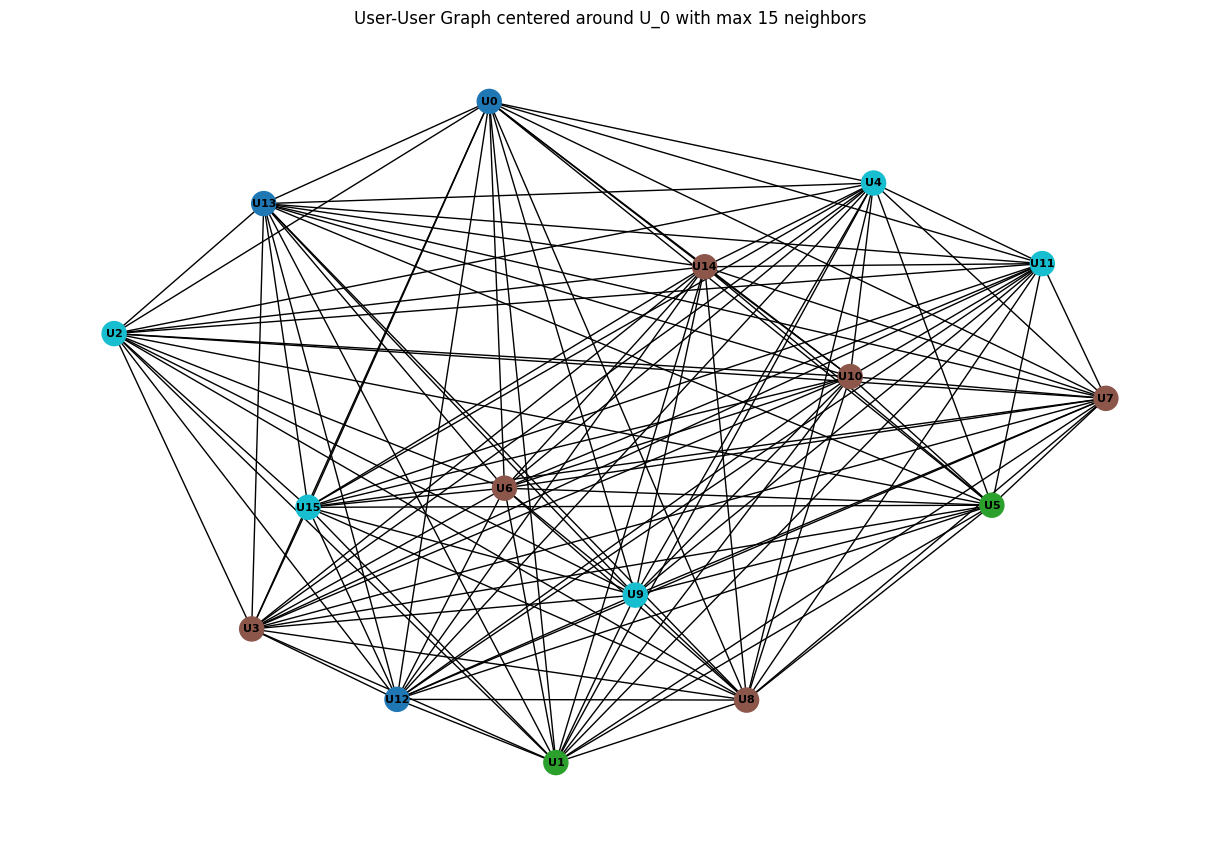

In [27]:


visualize_partial_uu_graph(enhanced_uu_graph, cluster_labels, user_id=0, max_neighbors=15)